### Movie Recommendations 

Predict how a user would rate a movie

Generate Ratings and present the recommendation list

In [1]:
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
import re

import boto3
from sagemaker import get_execution_role
import sagemaker

#SDK 2
from sagemaker.deserializers import JSONDeserializer

In [64]:
# Create predictor from existing endpoint

endpoint_name='fm-movie-v4'
predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name)

In [9]:
# Read dimension: number of unique columns
dim_movie
with open(r'ml-latest-small/movie_dimension.txt','r') as f:
    dim_movie = int(f.read())

In [10]:
dim_movie

10334

In [63]:
# Custom serializer

def fm_sparse_serializer(data):
    js = {'instances':[]}
    for row in data:
        
        column_list=row.tolist()
        value_list = np.ones(len(column_list), dtype=int).tolist()
        
        js['instances'].append(
            {
                "data": {
                    "features": {
                        'keys':column_list, 
                        'shape':[dim_movie], 
                        'values':value_list
                                }         
                        }
            }
        )
    
    return json.dumps(js)
    

In [65]:
# specify custom serializer

predictor.serializer.serialize = fm_sparse_serializer
predictor.serializer.content_type='application/json'

predictor.deserializer = JSONDeserializer()

In [7]:
predictor

In [11]:
# load the test libSVM file

test_file = r'ml-latest-small/user_movie_test.svm'


In [14]:
df_test = pd.read_csv(test_file, sep=' ', names=['rating','user_index','movie_index'])

In [15]:
df_test.head()

,rating,user_index,movie_index
0,2.5,426:1,943:1
1,3.0,110:1,10120:1
2,4.0,304:1,1554:1
3,5.0,273:1,867:1
4,2.0,18:1,3373:1


In [16]:
df_test.user_index = df_test.user_index.map(lambda x: int(x.split(':')[0]))
df_test.movie_index = df_test.movie_index.map(lambda x: int(x.split(':')[0]))

In [22]:
df_test

,rating,user_index,movie_index
0,2.5,426,943
1,3.0,110,10120
2,4.0,304,1554
3,5.0,273,867
4,2.0,18,3373
...,...,...,...
30246,1.0,599,1694
30247,3.5,569,1225
30248,4.0,314,1294
30249,3.5,488,2433


In [21]:
df_test.shape

(30251, 3)

In [66]:
# For large number of predictions we can split the input data into chunks
# array_split is convenient

def get_predictions(predictor, arr_features):
    
    predictions =[]
    print(arr_features.shape)
    for arr in np.array_split(arr_features,100):
        print(arr.shape,end=', ')
        if arr.shape[0]>0:
            result = predictor.predict(arr)
            predictions += [values['score'] for values in result['predictions']]
            
    return predictions

In [67]:
%time
predictions = get_predictions(predictor,df_test[['user_index','movie_index']].values)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
(30251, 2)
(303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302,

In [68]:
len(predictions)

30251

In [69]:
df_test['predictions']=predictions

In [71]:
df_test[['rating','predictions']]

,rating,predictions
0,2.5,2.851576
1,3.0,3.107434
2,4.0,4.020742
3,5.0,4.131877
4,2.0,2.294044
...,...,...
30246,1.0,2.512005
30247,3.5,3.144384
30248,4.0,3.269621
30249,3.5,2.677343


In [72]:
import sklearn.metrics as metrics

In [73]:
print('RMSE: ', metrics.mean_squared_error(df_test.rating, df_test.predictions)**.5)

RMSE:  0.9069811423766297


In [75]:
# Training Data Residuals

residuals = (df_test.predictions -df_test.rating)

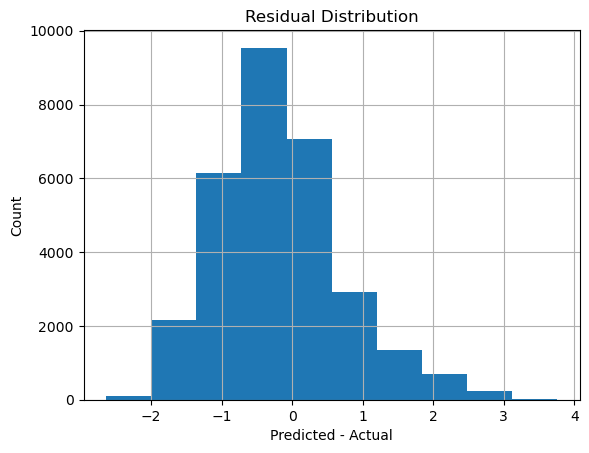

In [77]:
plt.hist(residuals)
plt.grid(True)
plt.xlabel('Predicted - Actual')
plt.ylabel('Count')
plt.title('Residual Distribution')
plt.show()

### Get Prediction for a single user and all movies

In [78]:
# load the one hot encoded svm for user 1

test_file = r'ml-latest-small/one_hot_enc_movies.svm'

In [ ]:
df_one_user_test = 